In [18]:
import os
import numpy as np
import pandas as pd

file_path = './test_results_r1.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

In [19]:
pivot_index = list(df_raw.columns[0:21])   # accuracy 전까지
remove_items = {
    'drift_model', 
    'pruning', 
    'retrain', 
    'Gmax', 
    'Gmin', 
    'G_ratio', 
    'n_rep', 
    'device', 
    'noise_model',
    'dataset',
    'mapping_scaling_omega',
    'model_type',
    }

pivot_index = [item for item in pivot_index if item not in remove_items]
pivot_index

['model',
 'IOparameter',
 'GDC',
 'pgm_noise_scale',
 'read_noise_scale',
 'drift_scale',
 'drift_var',
 'fix_seed',
 'inf_time']

In [20]:
df = df_raw.copy()

In [21]:
df = df[df['model']=='Resnet18']
df = df[df['pgm_noise_scale'] == 0]
# df = df[df['drift_model'] == 0.01]
df = df[df['Gmin']=='default']
# df = df[df['G_ratio']==25]
df = df[df['fix_seed']==42]

In [22]:
df_ideal_gdc = df[(df['IOparameter'] == 'ideal') & (df['GDC'] == 'on')]
df_ideal_gdcx = df[(df['IOparameter'] == 'ideal') & (df['GDC'] == 'off')]
df_nonideal_gdc = df[(df['IOparameter'] == 'non-ideal') & (df['GDC'] == 'on')]
df_nonideal_gdcx = df[(df['IOparameter'] == 'non-ideal') & (df['GDC'] == 'off')]

In [23]:
df['model_type'].unique()

array(['vanilla', '0.3_retrained', '0.4_retrained', '0.5_retrained',
       '0.6_retrained', '0.7_retrained', '0.3_pruned', '0.4_pruned',
       '0.5_pruned', '0.6_pruned', '0.7_pruned'], dtype=object)

In [24]:
df_o_o_pivot = df_ideal_gdc.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_o_o_pivot.reset_index(inplace=True) # index to columns 

df_o_x_pivot = df_ideal_gdcx.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_o_x_pivot.reset_index(inplace=True) # index to columns 

df_x_o_pivot = df_nonideal_gdc.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_x_o_pivot.reset_index(inplace=True) # index to columns 

df_x_x_pivot = df_nonideal_gdcx.pivot_table(index=pivot_index, columns='model_type', values='accuracy', aggfunc='mean')
df_x_x_pivot.reset_index(inplace=True) # index to columns 

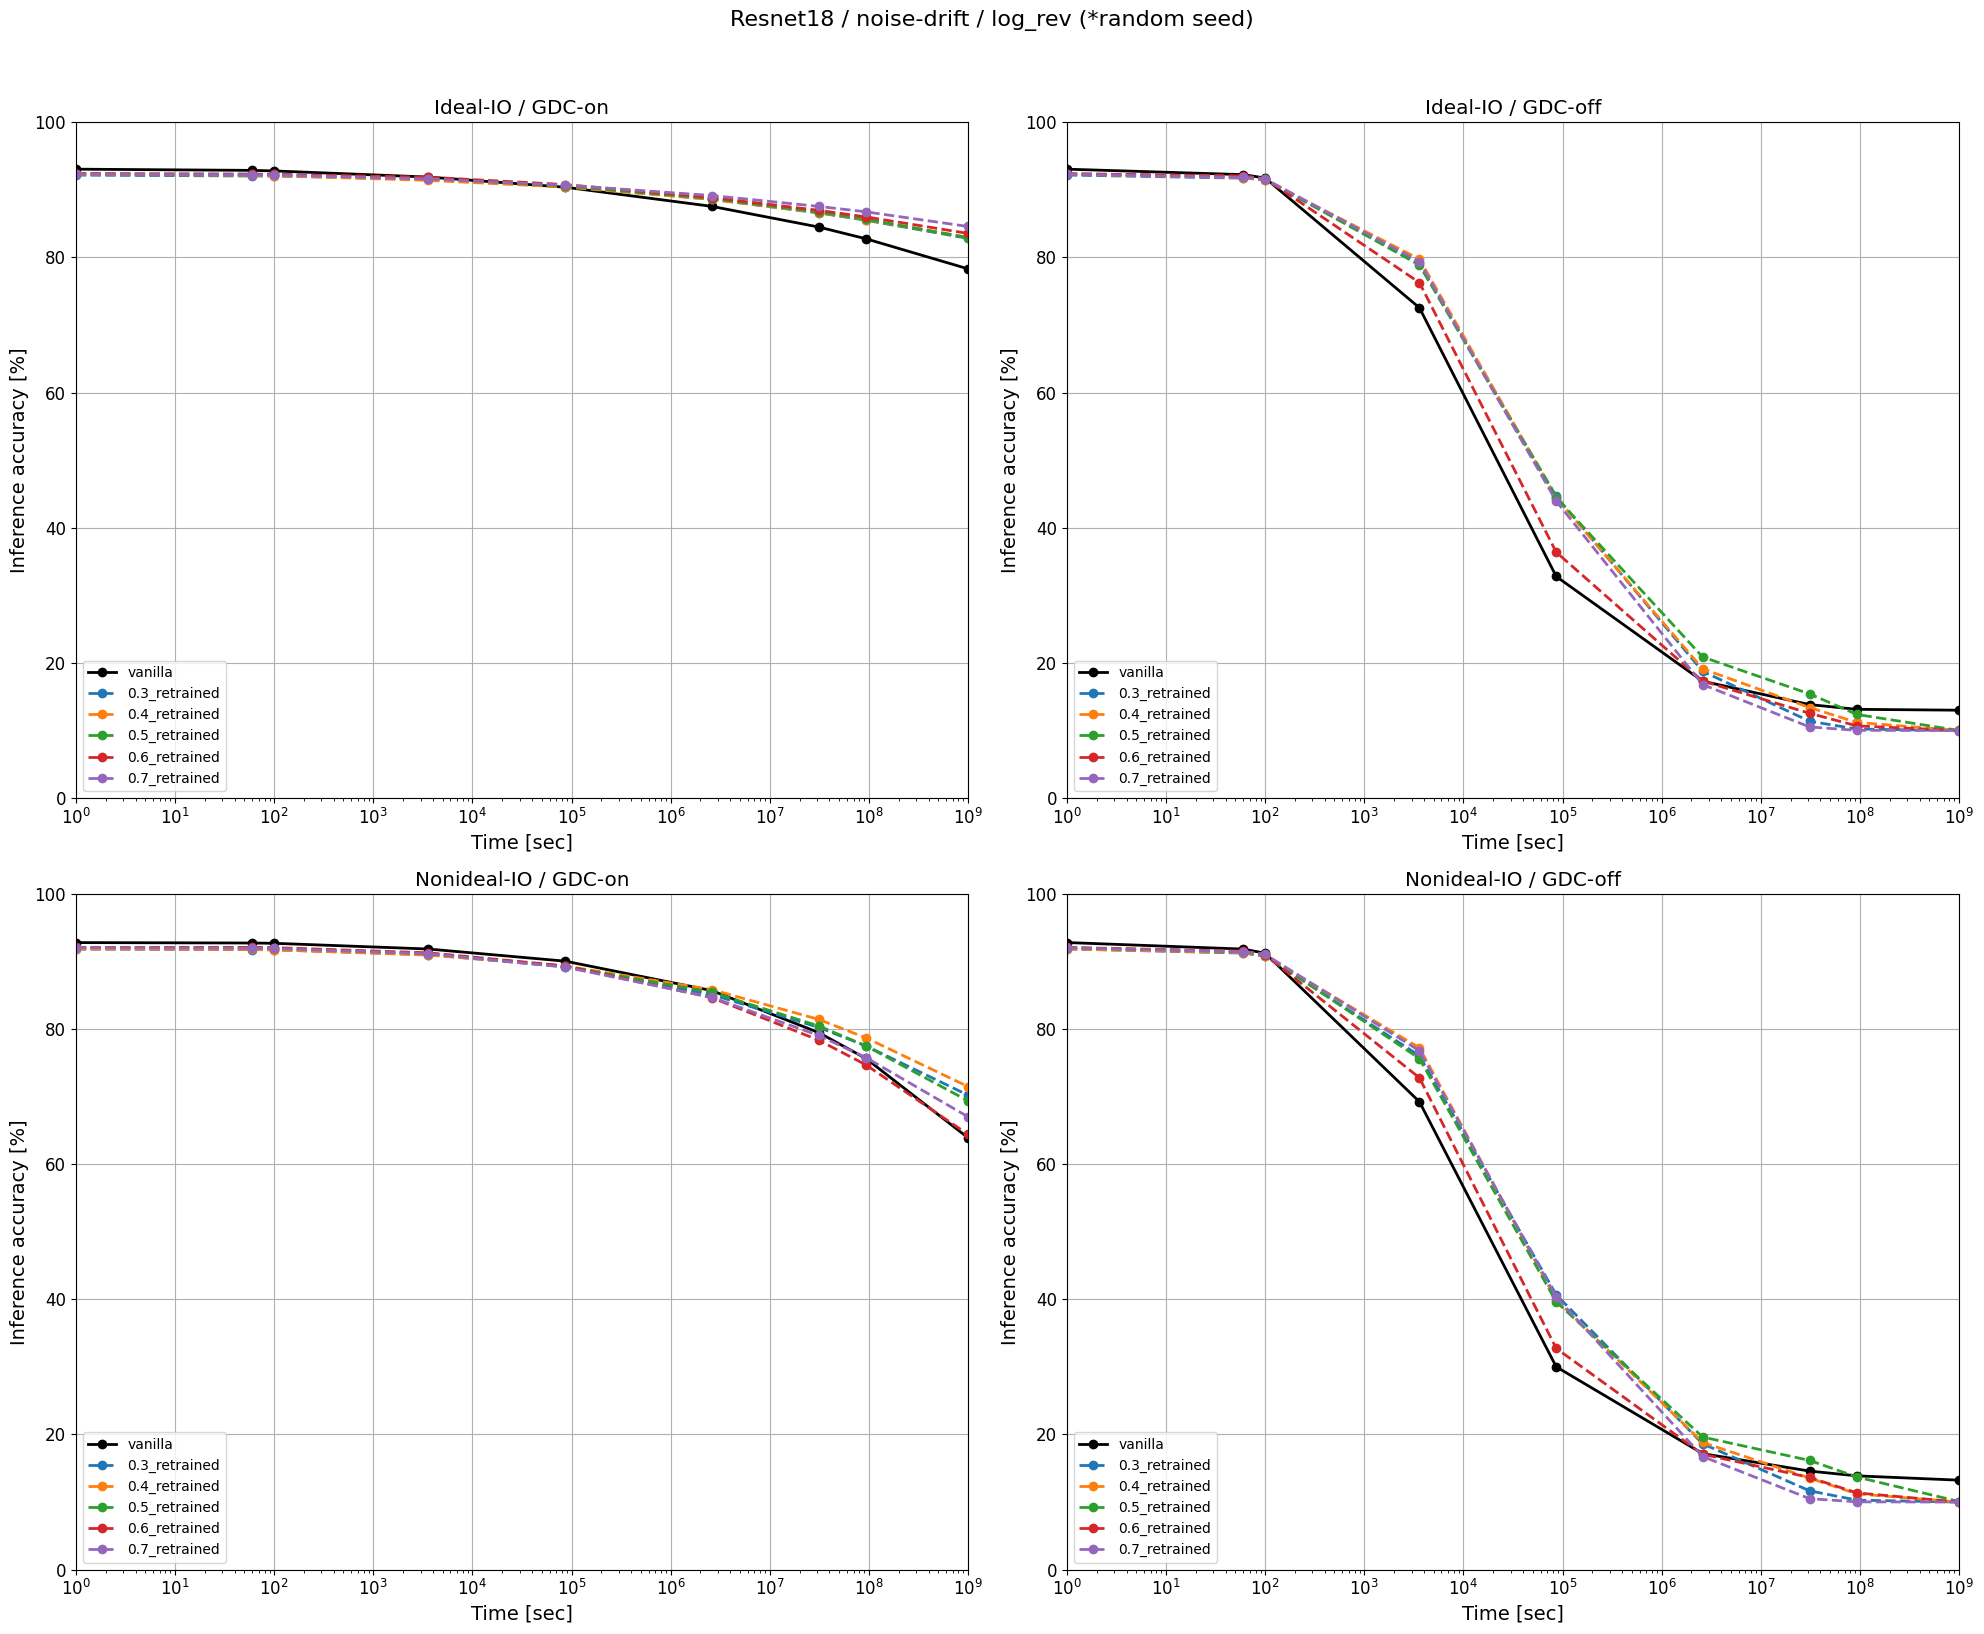

In [27]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plt.rcParams.update({'font.size': 12})

# Common plotting function
def plot_accuracy_re(ax, df_pivot, title):
    x = df_pivot['inf_time']
    
    ax.grid(True)
    ax.plot(x, df_pivot['vanilla'], marker='o', label='vanilla', linewidth=2, color='k')
    
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_retrained'], marker='o', 
                label=f'{ratio}_retrained', linestyle='--', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Inference accuracy [%]', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1000000000)
    ax.set_xscale('log')
    ax.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))

# Plot each condition
plot_accuracy_re(ax1, df_o_o_pivot, "Ideal-IO / GDC-on")
plot_accuracy_re(ax2, df_o_x_pivot, "Ideal-IO / GDC-off")
plot_accuracy_re(ax3, df_x_o_pivot, "Nonideal-IO / GDC-on")
plot_accuracy_re(ax4, df_x_x_pivot, "Nonideal-IO / GDC-off")


plt.suptitle("Resnet18 / noise-drift / log_rev (*random seed)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

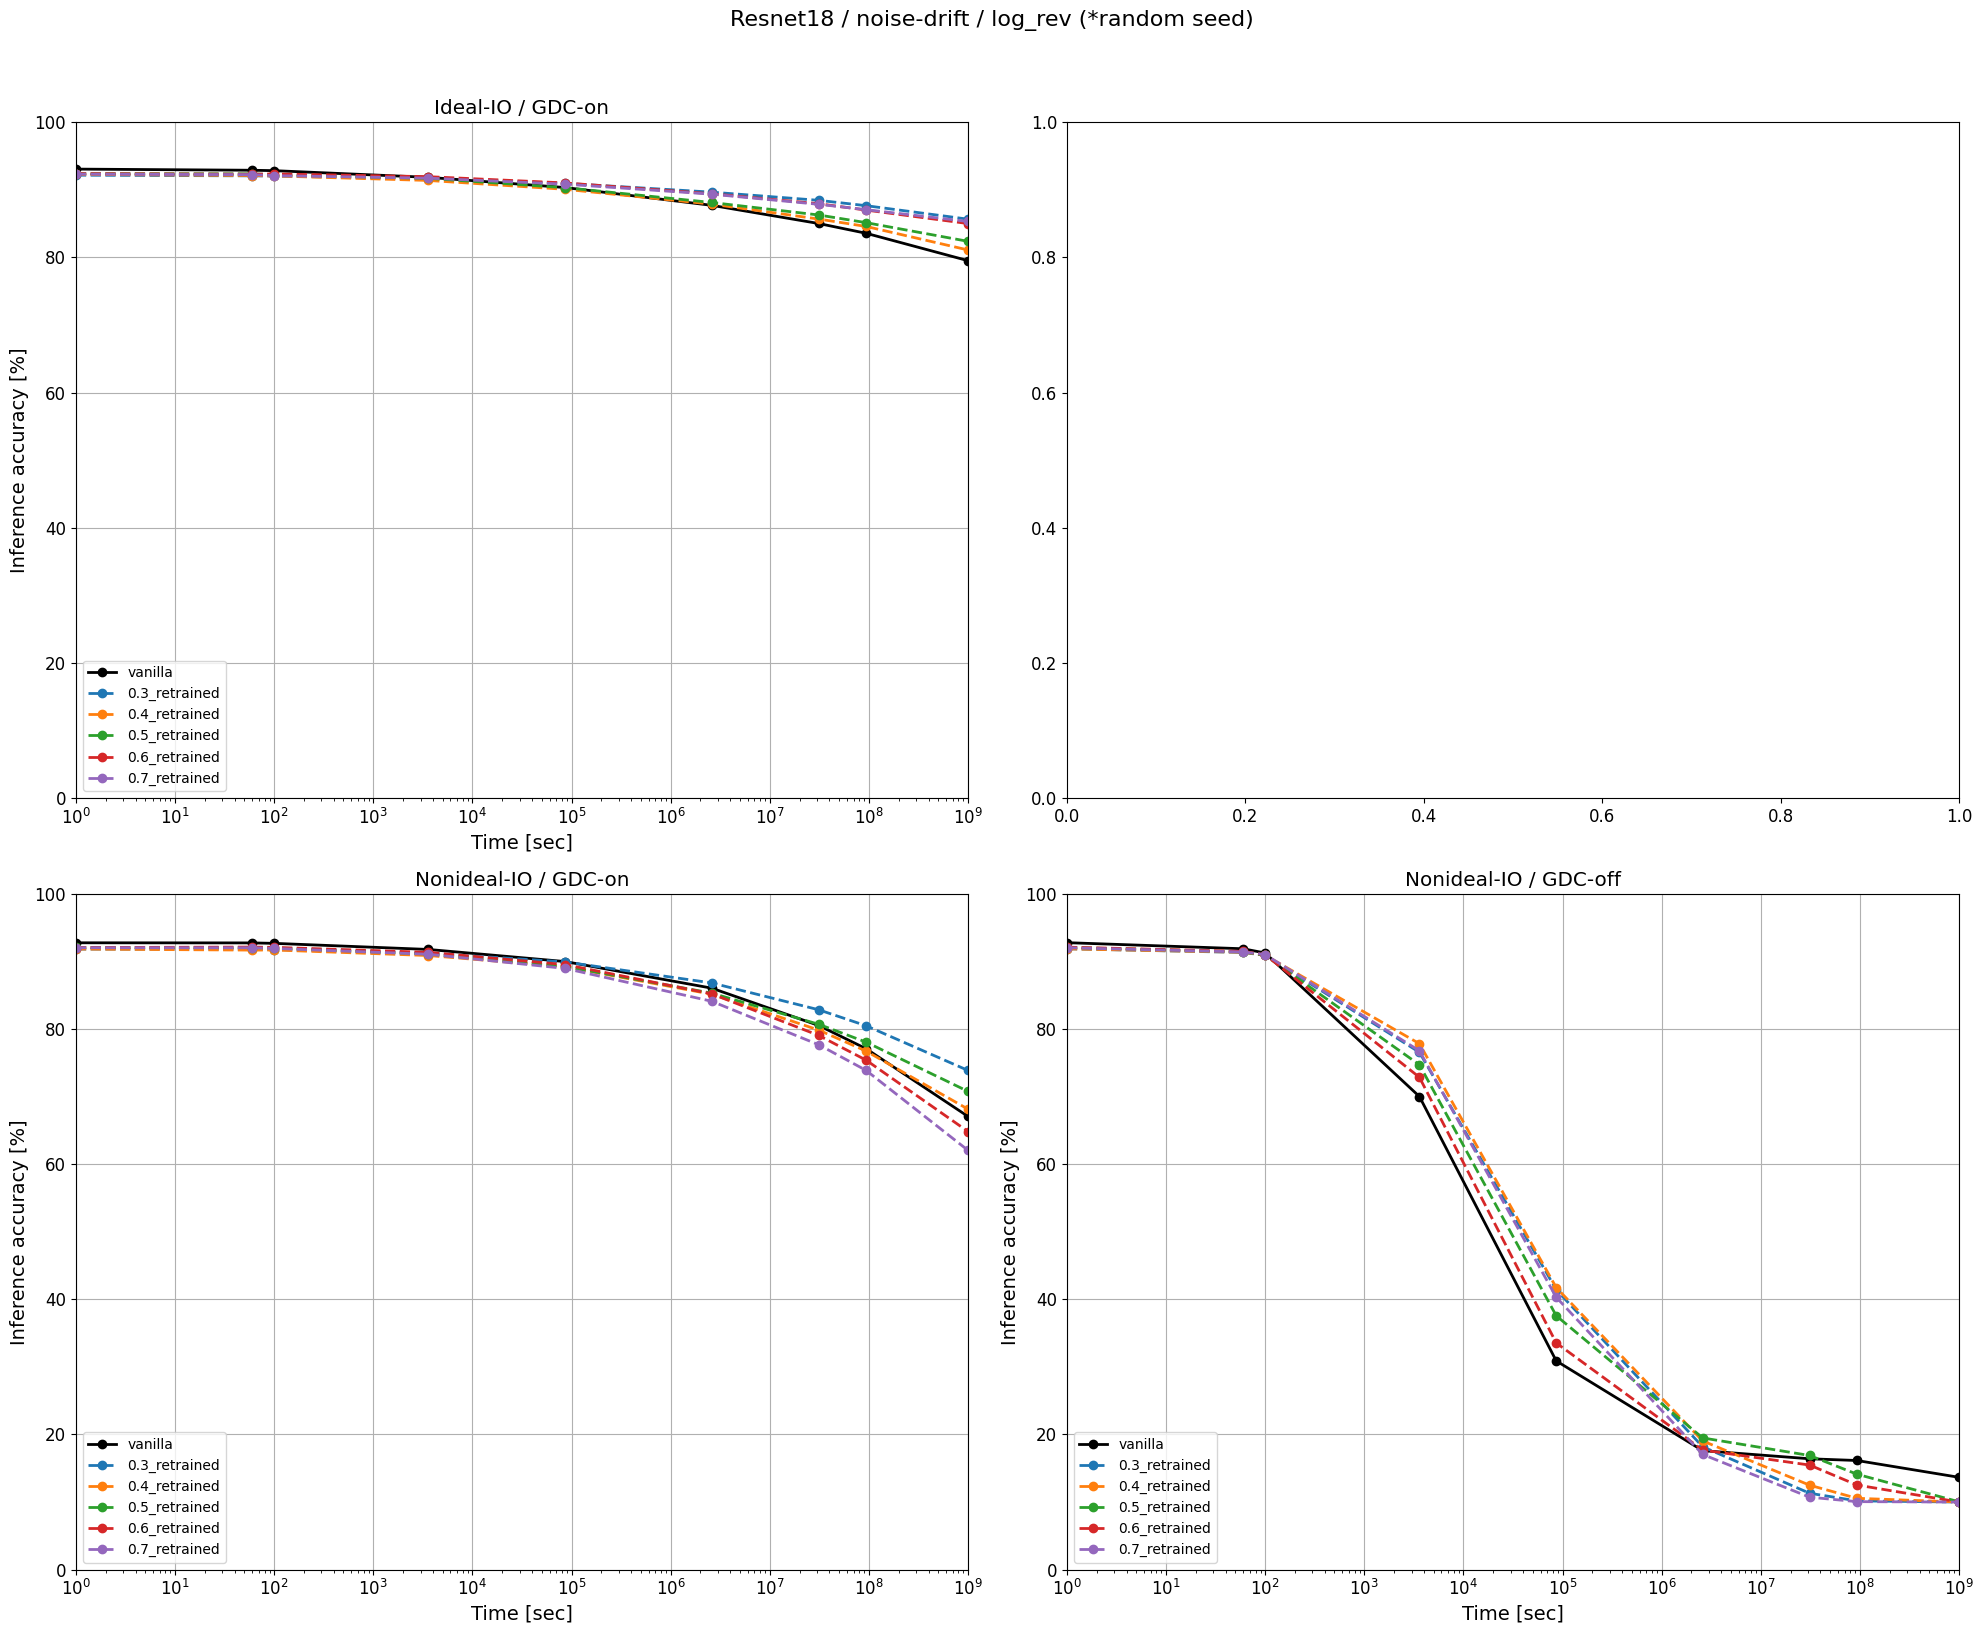

In [53]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plt.rcParams.update({'font.size': 12})

def plot_accuracy(ax, df_pivot, title):
    x = df_pivot['inf_time']
    
    ax.grid(True)
    ax.plot(x, df_pivot['vanilla'], marker='o', label='vanilla', linewidth=2, color='k')
    
    # Plot retrained models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_retrained'], marker='o', 
                label=f'{ratio}_retrained', linestyle='--', linewidth=2)
    
    # Plot pruned models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_pruned'], marker='^', 
                label=f'{ratio}_pruned', linestyle=':', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Inference accuracy [%]', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1000000000)
    ax.set_xscale('log')
    ax.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))

# Plot each condition
plot_accuracy_re(ax1, df_o_o_pivot, "Ideal-IO / GDC-on")
# plot_accuracy_re(ax2, df_o_x_pivot, "Ideal-IO / GDC-off")
plot_accuracy_re(ax3, df_x_o_pivot, "Nonideal-IO / GDC-on")
plot_accuracy_re(ax4, df_x_x_pivot, "Nonideal-IO / GDC-off")

plt.suptitle("Resnet18 / noise-drift / log_rev (*random seed)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

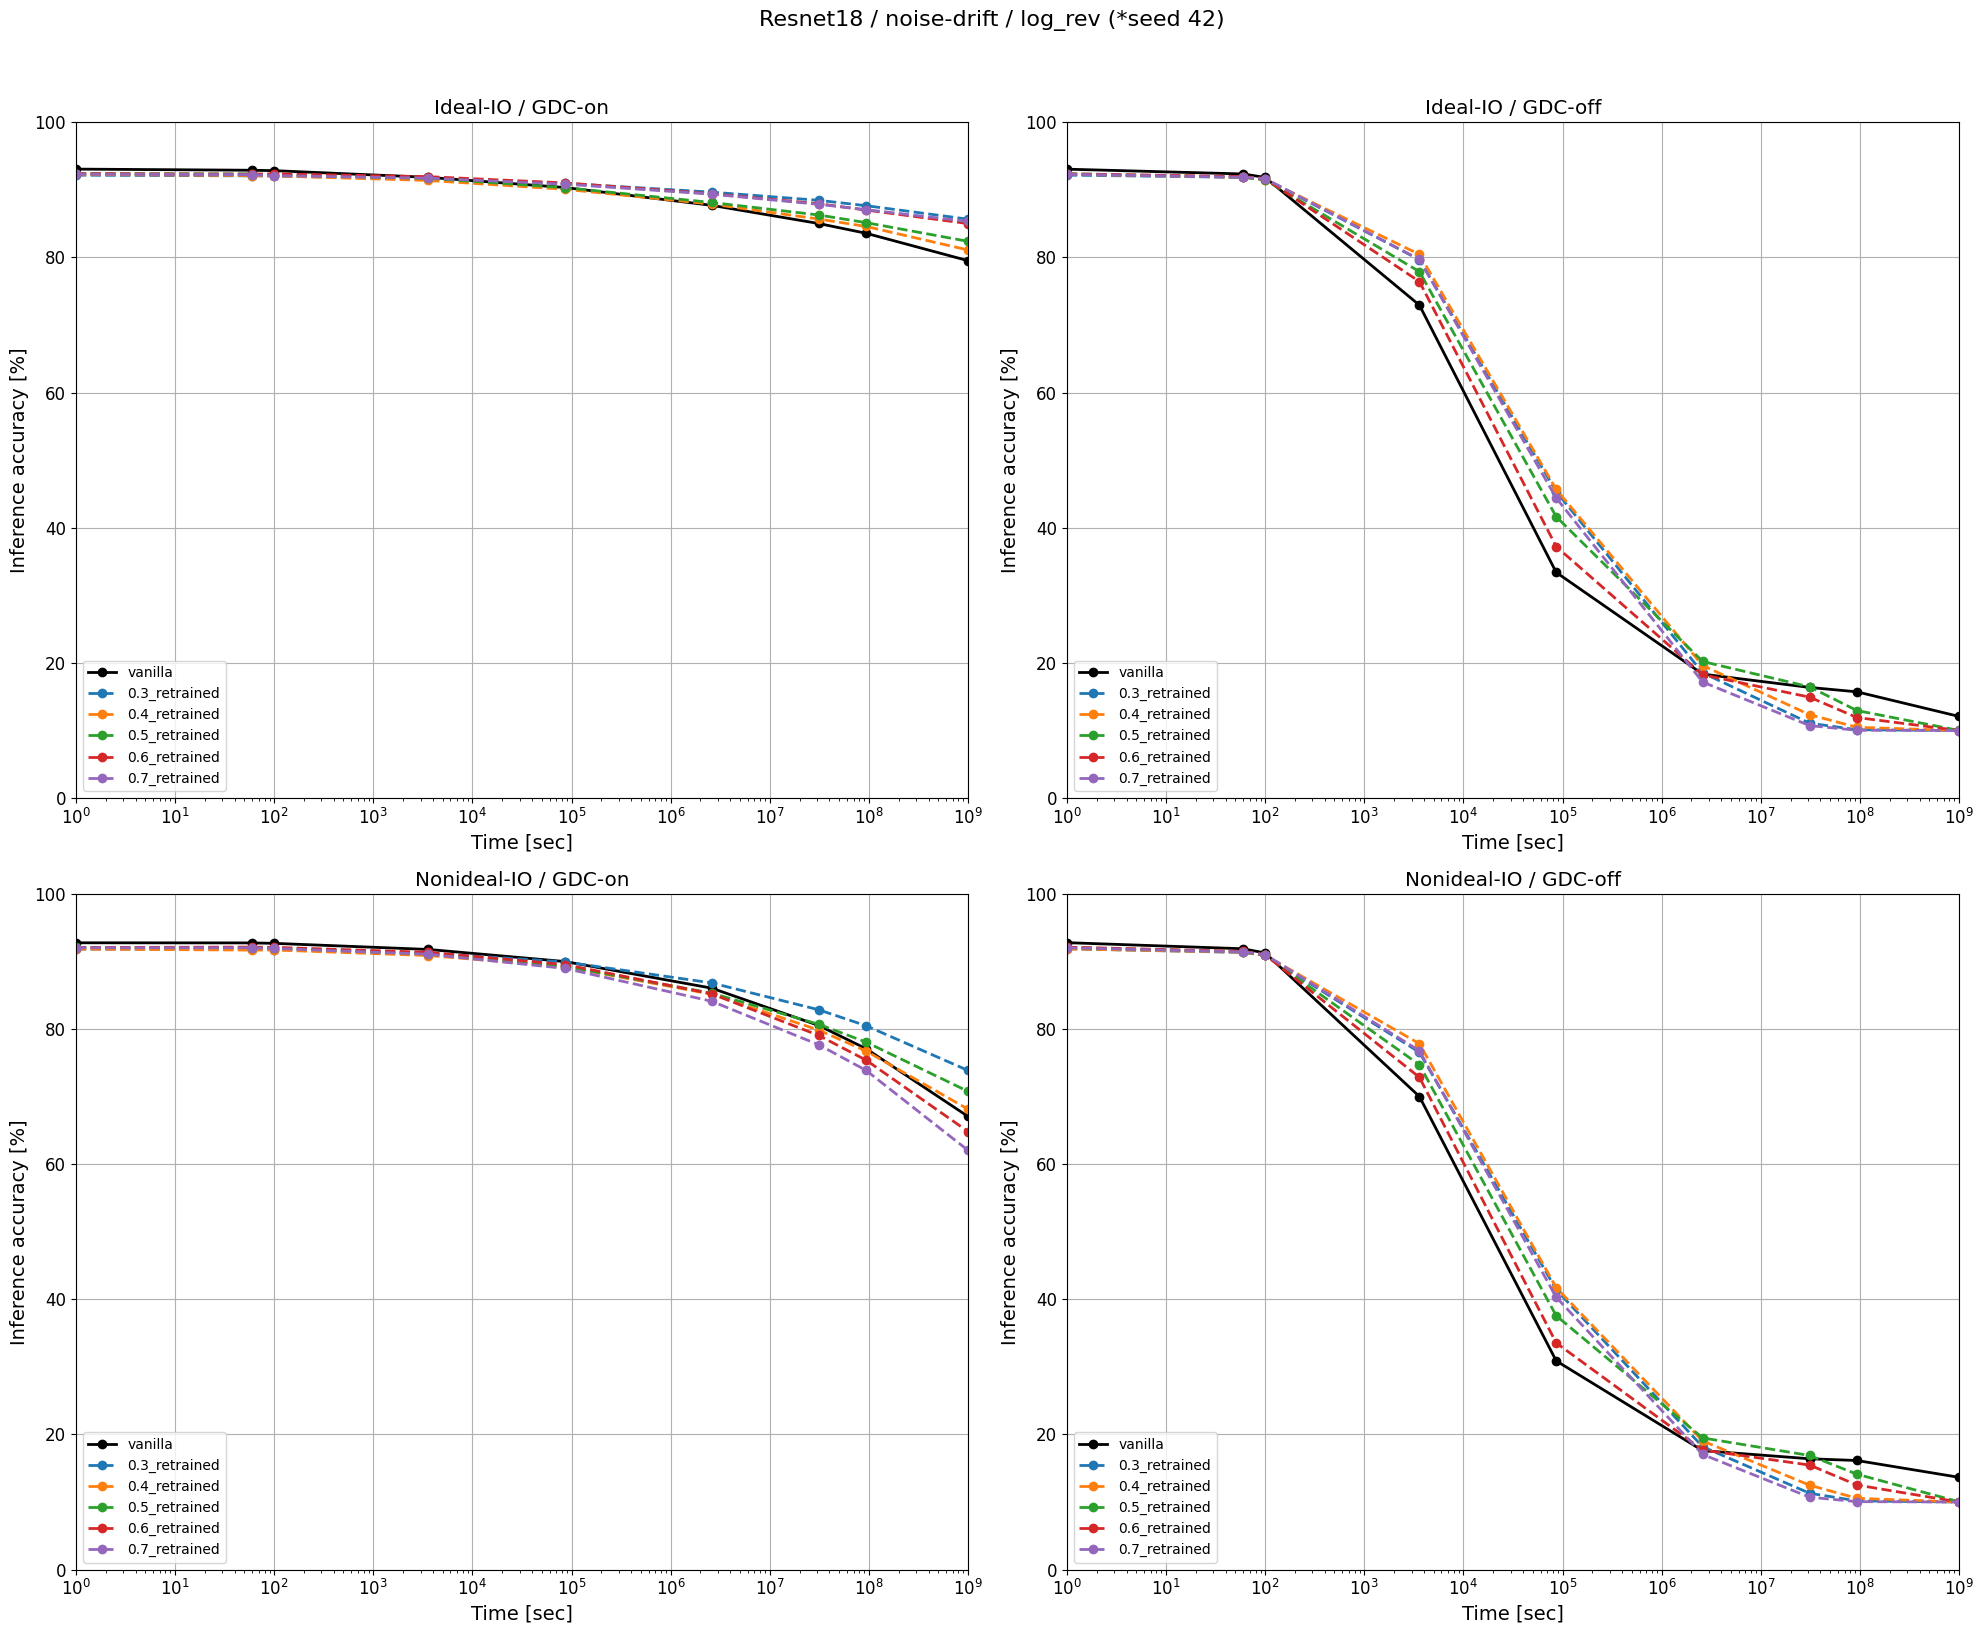

In [61]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
plt.rcParams.update({'font.size': 12})

def plot_accuracy_re(ax, df_pivot, title):
    x = df_pivot['inf_time']
    
    ax.grid(True)
    ax.plot(x, df_pivot['vanilla'], marker='o', label='vanilla', linewidth=2, color='k')
    
    # Plot retrained models
    for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
        ax.plot(x, df_pivot[f'{ratio}_retrained'], marker='o', 
                label=f'{ratio}_retrained', linestyle='--', linewidth=2)
    
    # # Plot pruned models
    # for ratio in ['0.3', '0.4', '0.5', '0.6', '0.7']:
    #     ax.plot(x, df_pivot[f'{ratio}_pruned'], marker='^', 
    #             label=f'{ratio}_pruned', linestyle=':', linewidth=2)
    
    ax.set_title(title)
    ax.set_xlabel('Time [sec]', fontsize=14)
    ax.set_ylabel('Inference accuracy [%]', fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(1, 1000000000)
    ax.set_xscale('log')
    ax.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))

# Plot each condition
plot_accuracy_re(ax1, df_o_o_pivot, "Ideal-IO / GDC-on")
plot_accuracy_re(ax2, df_o_x_pivot, "Ideal-IO / GDC-off")
plot_accuracy_re(ax3, df_x_o_pivot, "Nonideal-IO / GDC-on")
plot_accuracy_re(ax4, df_x_x_pivot, "Nonideal-IO / GDC-off")

plt.suptitle("Resnet18 / noise-drift / log_rev (*seed 42)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

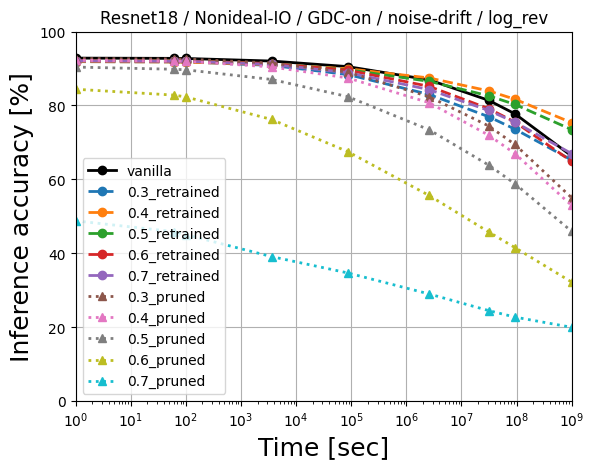

In [ ]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)

plt.plot(x,df_pivot['0.3_pruned'], marker='^', label = '0.3_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.4_pruned'], marker='^', label = '0.4_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.5_pruned'], marker='^', label = '0.5_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.6_pruned'], marker='^', label = '0.6_pruned', linestyle=':', linewidth=2)
plt.plot(x,df_pivot['0.7_pruned'], marker='^', label = '0.7_pruned', linestyle=':', linewidth=2)


plt.title("Resnet18 / Nonideal-IO / GDC-on / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

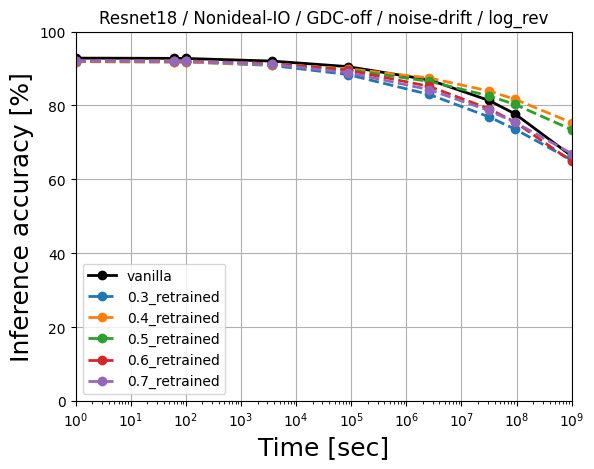

In [59]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)


plt.title("Resnet18 / Nonideal-IO / GDC-off / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

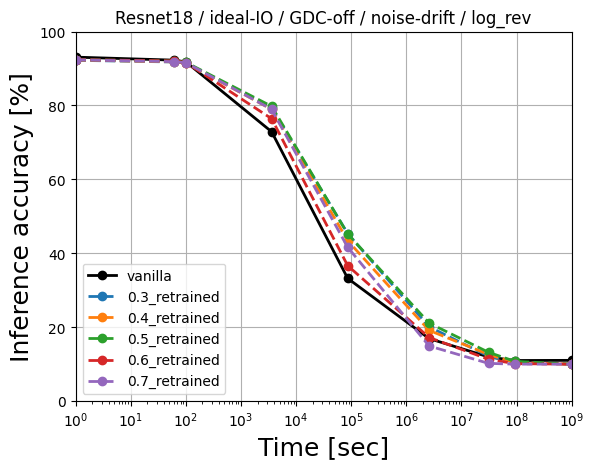

In [49]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)


plt.title("Resnet18 / ideal-IO / GDC-off / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

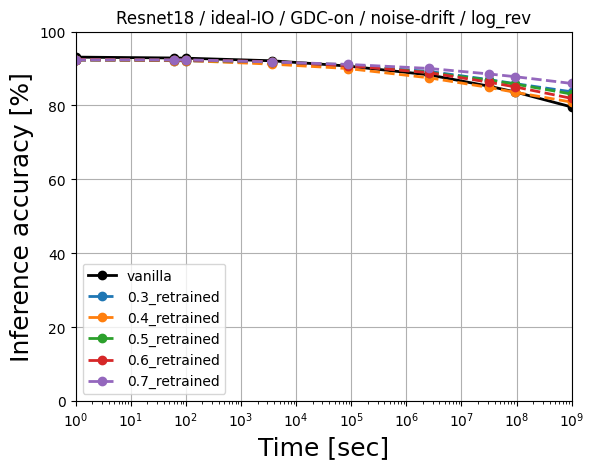

In [71]:
import matplotlib.pyplot as plt

x = df_pivot['inf_time']

plt.grid(True)

plt.plot(x,df_pivot['vanilla'], marker='o', label = 'vanilla', linewidth=2, color='k')

plt.plot(x,df_pivot['0.3_retrained'], marker='o', label = '0.3_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.4_retrained'], marker='o', label = '0.4_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.5_retrained'], marker='o', label = '0.5_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.6_retrained'], marker='o', label = '0.6_retrained', linestyle='--', linewidth=2)
plt.plot(x,df_pivot['0.7_retrained'], marker='o', label = '0.7_retrained', linestyle='--', linewidth=2)


plt.title("Resnet18 / ideal-IO / GDC-on / noise-drift / log_rev")
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(0.0, 0.0))
plt.xlabel('Time [sec]',fontsize=18)  
plt.ylabel('Inference accuracy [%]', fontsize=18) #, fontweight='demi'
# plt.xticks(fontsize/14)

plt.ylim(0,100)
plt.xlim(1,1000000000)
plt.xscale('log')
plt.show()

In [1]:
import random
import numpy as np
import torch

num_experiments = 5  # 실행 횟수

for i in range(num_experiments):
    seed = random.randint(0, 10000)  # 매번 랜덤한 seed 값 생성
    random.seed(seed)  # Python 랜덤 시드 설정
    np.random.seed(seed)  # NumPy 랜덤 시드 설정
    torch.manual_seed(seed)  # PyTorch 랜덤 시드 설정
    torch.cuda.manual_seed_all(seed)  # GPU 사용 시 시드 설정

    print(f"Experiment {i+1}: Using seed {seed}")


Experiment 1: Using seed 4558
Experiment 2: Using seed 5574
Experiment 3: Using seed 8156
Experiment 4: Using seed 7866
Experiment 5: Using seed 790


In [16]:
import random
import numpy as np
from typing import Optional
import torch
import os

def fix_seed(seed: Optional[int] = 42) -> None:
    """fix the random seed number

    Args:
        seed (Optional[int]): _the random seed number_. Defaults to 42.
    """
    
    random.seed(seed)   
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

fix_seed()
current_seed = np.random.randint(0, 99999)
print("Generated Seed:", current_seed)

fix_seed()
current_seed2 = np.random.randint(0, 99999)
print("Generated Seed2:", current_seed2)

Generated Seed: 15795
Generated Seed2: 15795
